# Homework 4: 2D Array Analysis, Plotting, and SciPy

In this homework exercise, we'll be analyzing electroencephalography (EEG) data. This data, taken from a study in which subjects listened to auditory tones of two different pitches: 200 Hz and 260 Hz.  There was a bit more to the study, but we'll be focusing only on one aspect of these tones: the 200 Hz tone was played much, much more often than the 260 Hz tone.  The hypothesis here is that we will pick up a different pattern of responses to the **Standard (200 Hz)** tones than the **Deviant (260 Hz)** tones.

This data was collected by Berti et al at the Swartz Center at the University of California, San Diego.  I downloaded it from their public repository and processed it a bit for our exercise.  The original dataset, along with more information about the study, can be found at http://headit.ucsd.edu/studies/9d557882-a236-11e2-9420-0050563f2612.  We are working with one electrode of Subject 8's data.

## Package Imports

As you import new packages throughout this exercise, put the import statements here, at the top.

In [1]:
import numpy as np
import os
from os import path
from scipy import io, signal, stats
import matplotlib.pyplot as plt
%matplotlib inline

np.set_printoptions(precision=2, suppress=True)


## Load the Data

This time, all of the data variables are stored in a single file: a **.mat file** at **Homework Sample Data/Homework 4/eeg_data.mat**.  MAT files are standard file format that Matlab saves in, so after this exercise, you'll be able to confidently exchange data with your colleagues who use Matlab! Cool, right?

The functions you need to load the data can be found in the **scipy.io** package.  I'll leave it to you to work out how to get the data.  In the end, though, you should have 3 variables:
  - **eeg**: This is a 2D NumPy array that has all every single trial, from both conditions (Standard and Deviant). 
  - **time**: This is a 1D array of stimulus-offset time points.  It tells you how long before or after the stimulus each EEG voltage measurement took place.  
  - **labels**: These are the condition labels for each trial.  There are only two values: one for the Standard trials, and one for the Deviant trials.  These labels are in the same order as the trials in the **eeg** matrix.  Unfortunately, you'll need to work out which number represents which trials (Hint: the rarer label is the Deviant condition).

In [2]:
load_dir = path.join("Homework Sample Data", "Homework 4")
os.listdir(load_dir)

['.gitattributes',
 'source_code.zip',
 'eeg_data.npy',
 'time.npy',
 'conditions.npy',
 'eeg_data.mat']

In [4]:
data_file = 'eeg_data.mat'
data = io.loadmat(path.join(load_dir, 'eeg_data.mat'))
data.keys()

dict_keys(['eeg', 'trial_time', '__version__', '__globals__', 'trial_labels', '__header__'])

In [5]:
eeg = data['eeg']
time = data['trial_time']
labels = data['trial_labels']

def print_shapes(*args):
    for mat in args:
        print(mat.shape, end=', ')  

print_shapes(eeg, time, labels)      

(1320, 180), (1, 180), (1, 1320), 

In [6]:
time = time.flatten()
labels = labels.flatten()
print_shapes(eeg, time, labels)

(1320, 180), (180,), (1320,), 

## Plot the Mean Evoked Potential

First, let's see what the overall data looks like.  Plot the mean EEG voltage over time, regardless of condition

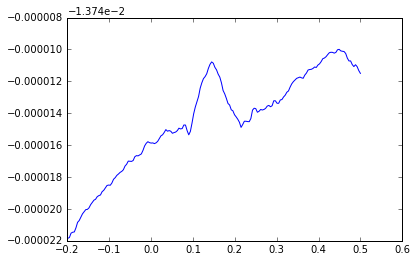

In [7]:
eeg_mean = np.mean(eeg, axis=0)
plt.plot(time, eeg_mean)

## Detrend the Data

You should see a nice peak around 150 msecs post-stimulus!  But wait, there's also a constant increase in voltage throughout the trial.  Well, This really makes it hard to analyse, and could be because of artifacts in the data.  After long examination, we decide to simply detrend the data to flatten it out and make that peak easier to recognize.

Now, NumPy doesn't have many great signal processing functions.  For that, we'll turn to **scipy.signal**!  They have a lot of great functions, and all of them work nicely with NumPy arrays--convenient, right?

For full scipy docs: http://docs.scipy.org/doc/scipy/reference/

For scipy's **detrend()** function, in its signal processing docs: http://docs.scipy.org/doc/scipy/reference/tutorial/signal.html#detrend

Take some time to look around the docs, and come back to them regularly--you never know what nice feature you might have overlooked!

### Detrend the Mean ERP signal, and plot the detrended version

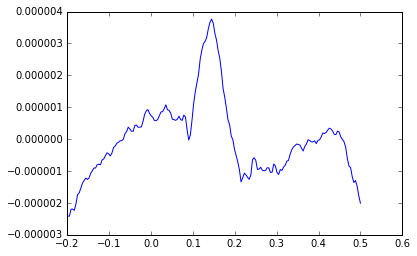

In [8]:
plt.plot(time, signal.detrend(eeg_mean))

## Detrend all of the trials, individually, then plot that mean!

Before you do it, though, think: Do you expect the result to be the same or different from removing the trend of the mean?

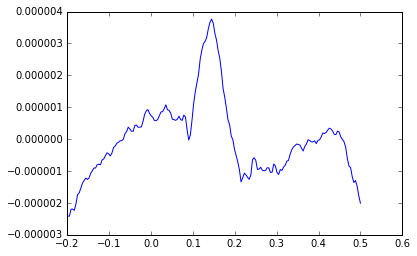

In [9]:
eeg_d = signal.detrend(eeg, axis=1)
plt.plot(time, eeg_d.mean(axis=0))

## Filter Out Data Beyond certain Time Points
Remove the EEG data occuring less than -150 msecs before the stimulus. Also remove all the data and greater than 400 msecs after the stimulus.  (We'll only work with the -150 - 400 msec time period from now on.)  Confirm it worked by plotting the mean response again.

In [10]:
time_mask = (time > -.150) & (time < .400)
time_f = time[time_mask]
eeg_df = eeg_d[:, time_mask]

print_shapes(eeg_df, time_f, labels)

(1320, 141), (141,), (1320,), 

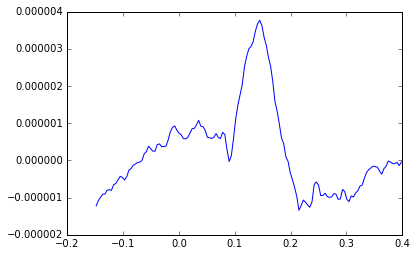

In [16]:
plt.plot(time_f, eeg_df.mean(axis=0))

## Separate the Two Conditions from one another, and plot their mean responses

### Which code represents which condition?

In [17]:
print(np.unique(labels))

[ 151.  251.]


In [18]:
labels_i = labels.astype(int)
labels_count = np.bincount(labels_i)

In [19]:
for label in np.unique(labels_i):
    print("{}: {}".format(label, labels_count[label]))

151: 1200
251: 120


### Create two 2D Matrices, one for each Condition (Standard and Deviant)

In [20]:
eeg_stand = eeg_df[labels == 151, :]
eeg_dev = eeg_df[labels == 251, :]

print_shapes(eeg_stand, eeg_dev)

(1200, 141), (120, 141), 

### Plot The two conditions' ERPs
Make the two lines different colors, and label them in the axis!

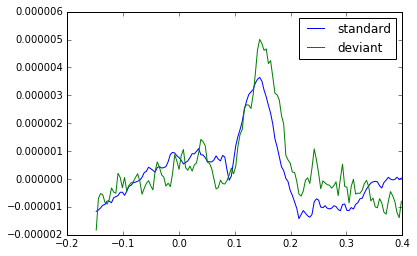

In [21]:
stand_mean = eeg_stand.mean(axis=0)
dev_mean = eeg_dev.mean(axis=0)

plt.plot(time_f, stand_mean, label='standard')
plt.plot(time_f, dev_mean, label='deviant')
plt.legend()

## Plot some shaded error bars, to help us see whether where there may be significant differences between the two conditions' responses

We'll just plot the **Standard Error of the Mean (SEM)**.  To calculate the SEM:

  1. Calculate the Standard Deviation of the EEG values at each time point.  (hint: you'll end up with two 1D arrays of std values, one for each condition)
  2. Divide the Standard Deviations by **the square root of one less the number of trials in the condition**.  
  
That's it!  Here's how the formula looks, in case my description was confusing.  In the formul below:
  - **STD**: Standard Deviation
  - **SEM**: Standard Error of the Mean
  - **N**: The number of trials

In [23]:
%%latex

$$ SEM = \frac{STD}{\sqrt{N - 1}}$$

<IPython.core.display.Latex object>

(Yes, that's right.  Latex formulas render properly in Jupyter Notebooks!)

### Calculate the SEM of the EEG Data at each Time Pont for each Condition

In [24]:
def calc_eeg_sem(mat):
    std = np.std(mat, axis=0)
    return std / np.sqrt(mat.shape[0] - 1)

stand_sem = calc_eeg_sem(eeg_stand)
dev_sem = calc_eeg_sem(eeg_dev)

###  Plot the ERP of each Condition again, this time with SEM shaded bars both above and below each condition's mean

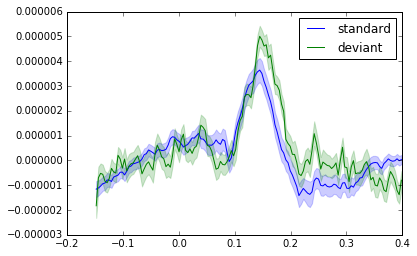

In [25]:
plt.plot(time_f, stand_mean, label='standard')
plt.plot(time_f, dev_mean, label='deviant')
plt.legend()
plt.fill_between(time_f, stand_mean - stand_sem, stand_mean + stand_sem, alpha=.2, color='b')
plt.fill_between(time_f, dev_mean - dev_sem, dev_mean + dev_sem, alpha=.2, color='g')


# Select the Peak, and Statistically Compare their Heights Between Conditions

Let's simplify this analysis, and say that we're now just interested in finding out whether the EEG response around 140 Hz was significantly different between the two conditions

### Get the Mean EEG Voltage between 130 and 150 msecs post-stimulus for each trial. 
Let's call this the **N140 Response**

In [26]:
mask_n140 = (time_f > .130) & (time_f < .15)

n140_stand = eeg_stand[:, mask_n140].mean(axis=1)
n140_dev = eeg_dev[:, mask_n140].mean(axis=1)

print_shapes(n140_stand, n140_dev)

(1200,), (120,), 

In [28]:
n140_stand_mean = n140_stand.mean(axis=0)
n140_dev_mean = n140_dev.mean(axis=0)

[n140_stand_mean, n140_dev_mean]

[3.4738281141755711e-06, 4.2578202964607106e-06]

### Filter out any outlier trials -- trials that are extremely different from the rest.

#### Make a histogram showing the distribution of N140s across all conditions

-0.000231596601421
0.000376048241303


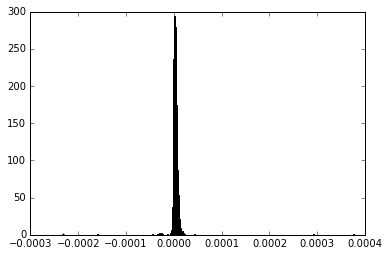

In [29]:
n140_all = eeg_df[:, mask_n140].mean(axis=1)
_ = plt.hist(n140_all, bins=300)
print(n140_all.min())
print(n140_all.max())

#### Remove outlier trials

In [30]:
n140_stand_f = n140_stand[(n140_stand > -.0001) & (n140_stand < .0001)]
n140_dev_f = n140_dev[(n140_dev > -.0001) & (n140_dev < .0001)]

### Make a Bar Plot comparing the N140 Response between the two conditions.  

Don't forget error bars, also showing the SEM!

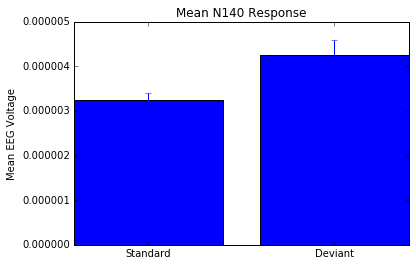

In [31]:
n140_stand_mean = n140_stand_f.mean()
n140_dev_mean = n140_dev_f.mean()

n140_stand_sem = n140_stand_f.std() / np.sqrt(len(n140_stand_f) - 1)
n140_dev_sem = n140_dev_f.std() / np.sqrt(len(n140_dev_f) - 1)

fix, ax = plt.subplots()
ax.bar([0, 1], [n140_stand_mean, n140_dev_mean], yerr=[n140_stand_sem, n140_dev_sem])
ax.set_xticks([0.4, 1.4])
ax.set_xticklabels(['Standard', 'Deviant'])
ax.set_title('Mean N140 Response')
ax.set_ylabel('Mean EEG Voltage')

## Do a Statistical Test comparing N140 Between Responses to See if their means are different.

Let's do a **Mann-Whitney U Test**.   It's a test that compares the two conditions without making any assumptions about how each condition is distributed.  

Lots of good statistical tests can be found at **scipy.stats**, yet another subpackage of Scipy: http://docs.scipy.org/doc/scipy-0.17.0/reference/stats.html

### Are the N140 Responses signficantly different between conditions?

In [32]:
mw_result = stats.mannwhitneyu(n140_stand_f, n140_dev_f)
mw_result

MannwhitneyuResult(statistic=61126.0, pvalue=0.0073781136767421731)

### Add the statistical values to your bar plot!

Even if it isn't a significant difference, it's nice to know what the actual values are when we look at a plot, especially if there are only a few values to be made.  Put the U value and the P value on the bar plot you made earlier, in text!

Intro on Text in Matplotlib: http://matplotlib.org/users/text_intro.html

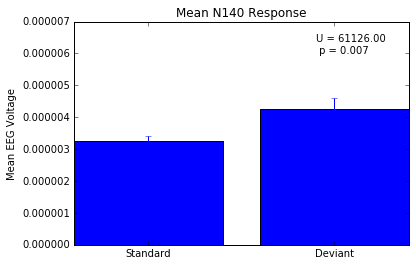

In [33]:
fix, ax = plt.subplots()
ax.bar([0, 1], [n140_stand_mean, n140_dev_mean], yerr=[n140_stand_sem, n140_dev_sem])
ax.set_xticks([0.4, 1.4])
ax.set_xticklabels(['Standard', 'Deviant'])
ax.set_title('Mean N140 Response')
ax.set_ylabel('Mean EEG Voltage')
ax.set_ylim(0, .000007)
ax.text(1.3, .000006, 'U = {:.2f}\n p = {:.3f}'.format(mw_result.statistic, mw_result.pvalue))

## Sandbox

What other analysis steps do you think could/should be done on this data?  Try them out here!